# Getting Started with Hyperkite

This short introduction uses Hyperkite to:

1. Build a neural network that classifies handwritten images (MNIST).

2. Optimize the hyperparameters of the model using pytorch

This tutorial is part of the original [Hyperkite Documentation](https://hyperkite.ai/docs/getting-started/).

# Install

Install the Hyperkite package by running the following command in your terminal:

pip install hyperkite

For installation instructions for other packages, visit the [PyTorch](https://pytorch.org/) website.

In [118]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torch.autograd import Variable
from torchvision import transforms
from torchvision.datasets import MNIST

SEED = 1

cuda = torch.cuda.is_available()

if cuda:
    torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

# Loading Data
We obtain a collection of handwritten digits by loading the [Digit Dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_digits_last_image.html) from sklearn:

In [119]:
train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )
valid = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

train_valid_split = 55000
train.data = train.data[:train_valid_split]
valid.data = valid.data[train_valid_split:]

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)
valid_loader = dataloader.DataLoader(valid, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

print(f'Training set    ({len(train)} images)')
print(f'Validation set  ({len(valid)} images)')
print(f'Test set        ({len(test)} images)')

Training set    (55000 images)
Validation set  (5000 images)
Test set        (10000 images)


## Model

In [120]:
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [121]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train

Training time:

- CPU, about 1 minute and 30 seconds
- GPU, about 10 seconds

In [83]:
for epoch in range(2): # Loop over the dataset 2 times

    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 20 == 0:
            print(f'Epoch {epoch+1}, Iter {i+1}, Loss: {running_loss}')
            running_loss = 0.0

print('Finished Training')

Epoch 1, Iter 1, Loss: 0.13424350321292877
Epoch 1, Iter 21, Loss: 3.043186515569687
Epoch 1, Iter 41, Loss: 2.970725256949663
Epoch 1, Iter 61, Loss: 2.6603646464645863
Epoch 1, Iter 81, Loss: 2.693312082439661
Epoch 1, Iter 101, Loss: 3.2401433773338795
Epoch 1, Iter 121, Loss: 3.199323885142803
Epoch 1, Iter 141, Loss: 3.13962459936738
Epoch 1, Iter 161, Loss: 3.298606876283884
Epoch 1, Iter 181, Loss: 2.9054590053856373
Epoch 1, Iter 201, Loss: 3.1090864278376102
Epoch 1, Iter 221, Loss: 3.124228548258543
Epoch 1, Iter 241, Loss: 3.1147813349962234
Epoch 1, Iter 261, Loss: 2.6570335626602173
Epoch 1, Iter 281, Loss: 2.974055051803589
Epoch 1, Iter 301, Loss: 2.9900256022810936
Epoch 1, Iter 321, Loss: 2.08127080835402
Epoch 1, Iter 341, Loss: 2.6153419092297554
Epoch 1, Iter 361, Loss: 3.225513406097889
Epoch 1, Iter 381, Loss: 2.571315586566925
Epoch 1, Iter 401, Loss: 3.2504887506365776
Epoch 1, Iter 421, Loss: 2.822856791317463
Epoch 1, Iter 441, Loss: 2.825624216347933
Epoch 1,

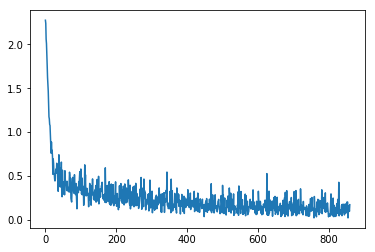

In [84]:
plot(losses)

## Evaluate

In [85]:
test_x = Variable(test_loader.dataset.test_data.type_as(torch.FloatTensor()))
test_y = Variable(test_loader.dataset.test_labels)
if cuda:
    test_x, test_y = test_x.cuda(), test_y.cuda()
    
model.eval()
output = model(test_x)
pred = output.data.max(1)[1]
d = pred.eq(test_y.data).cpu()
accuracy = d.sum() / d.size()[0]

print(f'Accuracy without Hyperkite: {accuracy}')
print(f'Accuracy with Hyperkite: {accuracy}')

Accuracy without Hyperkite: 0
Accuracy with Hyperkite: 0


/home/tycho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':
